# German Traffic Sign Classification

### Author: Nick Pelikan
_2018-03-04_

This notebook operationalizes a traffic sign classification CNN, utilizing transfer learning from a pre-trained imageNet CNN. 

Data is from the German traffic signs dataset, available at http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset.

The purpose of this is mostly exploratory -- to investigate transfer learning vs hand-built networks...

In [1]:
NUM_CLASSES = 43
IMAGE_SIZE = 75

In [2]:
from matplotlib import pyplot as plt
%matplotlib notebook

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json, Model
from keras import layers

from keras.optimizers import SGD
from keras.utils import np_utils
from keras.utils.training_utils import multi_gpu_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

from keras.applications import VGG16, Xception # for transfer learning

import tensorflow as tf
import numpy as np

from skimage import io, color, exposure, transform
from sklearn.model_selection import train_test_split
import os
import itertools
import glob
import h5py
import pandas as pd

np.set_printoptions(threshold=np.nan)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Training Images to List

In [3]:
root_dir = 'data/GTSRB/Final_Training/Images/'
imgs = []
labels = []

all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))
np.random.shuffle(all_img_paths)

classes = pd.read_csv('data/signnames.csv')
class_names = {}
for i, row in classes.iterrows():
    class_names[str(row[0])] = row[1]

for img_path in all_img_paths:
    try:
        img = io.imread(img_path)
        label = int(img_path.split("/")[-2])
        imgs.append(img)
        labels.append(label)

        if len(imgs)%5000 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
    except (IOError, OSError):
        print('missed', img_path)
        pass

# X = np.array(imgs, dtype='float32')
# Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]


Processed 5000/39209
Processed 10000/39209
Processed 15000/39209
Processed 20000/39209
Processed 25000/39209
Processed 30000/39209
Processed 35000/39209


### Exploration:

Let's take a look at a few examples:

Speed limit (70km/h)


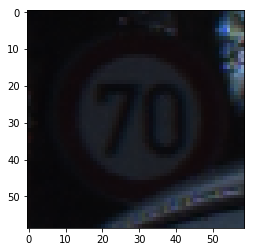

Children crossing


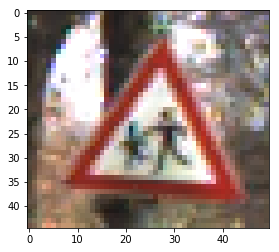

No entry


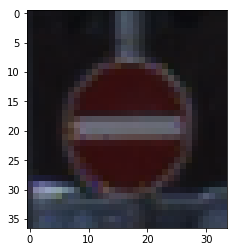

Wild animals crossing


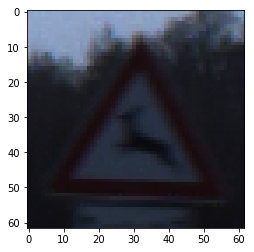

Priority road


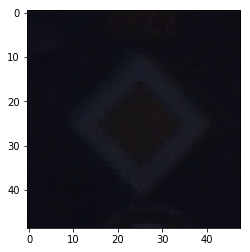

In [4]:
for i in range(5):
    print(class_names[str(labels[i])])
    plt.imshow(imgs[i])
    plt.show()

-----
### Preprocessing

First, these aren't quite scaled correctly -- let's fix that:

In [5]:
imgs_rescaled = list(map(lambda img: transform.resize(img, (IMAGE_SIZE, IMAGE_SIZE)), imgs))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Speed limit (70km/h)


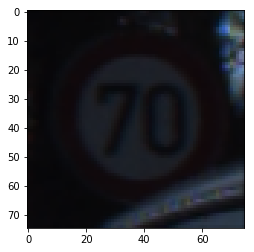

Children crossing


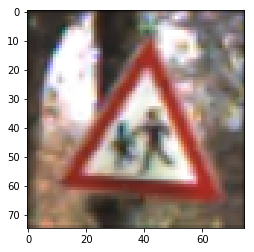

No entry


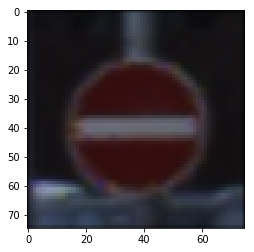

In [6]:
for i in range(3):
    print(class_names[str(labels[i])])
    plt.imshow(imgs_rescaled[i])
    plt.show()

Many of these are in shadow --  let's correct that using adaptive histogram normalization

In [7]:
def hist_normalize(img):
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_adapthist(hsv[:,:,2], clip_limit=.03)
    img = color.hsv2rgb(hsv)
    return(img)

imgs_scalenorm = list(map(hist_normalize, imgs_rescaled))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Speed limit (70km/h)


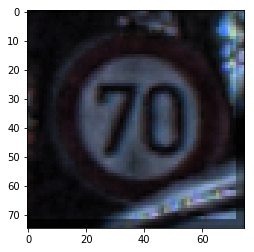

Children crossing


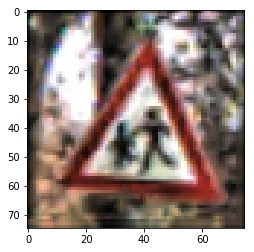

No entry


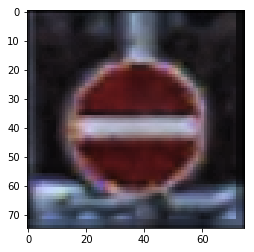

In [8]:
for i in range(3):
    print(class_names[str(labels[i])])
    plt.imshow(imgs_scalenorm[i])
    plt.show()

Much Better. Now let's build the training set.

In [9]:
X = np.array(imgs_scalenorm, dtype='float32')
Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]

-----

## Test #1 -- Transfer learning

Creating the base. For this I'm using Xception w/ imagenet weights as it's a fairly well developed classifier trained on a general-purpose library. It's a bit deeper than the VGG series, etc, so it's a bit more Chihuaha than German Shepherd in terms of training time, but it works for these purposes.

In [10]:
conv_base = Xception(weights='imagenet', include_top=False, input_shape=X.shape[1:])

83689472/83683744 [==============================] - 6s 0us/step


In [11]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 37, 37, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 37, 37, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

Let's add some new layers, shall we?

In [12]:
with tf.device("/cpu:0"):
    vgl = conv_base.output
    flt_b = layers.Flatten()(vgl)
    d1 = layers.Dense(1024, activation="relu")(flt_b)
    dr1 = layers.Dropout(.2)(d1)
    d2 = layers.Dense(512, activation="relu")(dr1)
    pre = layers.Dense(NUM_CLASSES, activation="softmax")(d2)

model = Model(inputs=conv_base.input, outputs=pre)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
pmodel = multi_gpu_model(model, gpus=2)
pmodel.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

A Few convenience variables...

In [13]:
EPOCHS = 20
BATCH_SIZE = 32

In [14]:
history = pmodel.fit(X, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=.2, shuffle=True)

Train on 31367 samples, validate on 7842 samples
Epoch 1/20
31367/31367 [==============================] - 204s 6ms/step - loss: 1.8474 - acc: 0.4331 - val_loss: 0.7114 - val_acc: 0.7600
Epoch 2/20
31367/31367 [==============================] - 196s 6ms/step - loss: 0.3903 - acc: 0.8755 - val_loss: 0.3953 - val_acc: 0.9135
Epoch 3/20
31367/31367 [==============================] - 196s 6ms/step - loss: 0.1226 - acc: 0.9676 - val_loss: 0.0771 - val_acc: 0.9807
Epoch 4/20
31367/31367 [==============================] - 197s 6ms/step - loss: 0.1243 - acc: 0.9691 - val_loss: 0.1236 - val_acc: 0.9745
Epoch 5/20
31367/31367 [==============================] - 196s 6ms/step - loss: 0.0362 - acc: 0.9911 - val_loss: 0.0716 - val_acc: 0.9819
Epoch 6/20
31367/31367 [==============================] - 196s 6ms/step - loss: 0.0406 - acc: 0.9894 - val_loss: 0.0166 - val_acc: 0.9949
Epoch 7/20
31367/31367 [==============================] - 196s 6ms/step - loss: 0.0351 - acc: 0.9915 - val_loss: 0.3676 - v

Testing Data...

In [15]:
test = pd.read_csv('data/GT-final_test.csv',sep=';')

In [16]:
def t_preprocess(ip):
    ig = io.imread(ip)
    ig = transform.resize(ig, (IMAGE_SIZE, IMAGE_SIZE))
    ig = hist_normalize(ig)
    return(ig)


X_test = []
y_test = []
i = 0
for file_name, class_id  in zip(list(test['Filename']), list(test['ClassId'])):
    img_path = os.path.join('data/Final_Test/Images/',file_name)
    X_test.append(t_preprocess(img_path))
    y_test.append(class_id)
    
X_test = np.array(X_test)
y_test = np.eye(NUM_CLASSES, dtype='uint8')[y_test]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [17]:
score, acc = model.evaluate(x=X_test, y=y_test,
                            batch_size=BATCH_SIZE)
print('Test score:', score)
print('Test accuracy:', acc)

12630/12630 [==============================] - 21s 2ms/step
Test score: 0.08844543221490339
Test accuracy: 0.9832145684594119


In [19]:
from sklearn.metrics import classification_report, confusion_matrix, log_loss
rn = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test)

vp = np.argmax(y_pred, axis=1)
print(classification_report(rn, vp, target_names=csort))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       1.00      1.00      1.00        60
                              Speed limit (30km/h)       0.99      1.00      0.99       720
                              Speed limit (50km/h)       1.00      1.00      1.00       750
                              Speed limit (60km/h)       0.99      0.96      0.97       450
                              Speed limit (70km/h)       1.00      0.97      0.98       660
                              Speed limit (80km/h)       0.96      0.99      0.98       630
                       End of speed limit (80km/h)       0.94      1.00      0.97       150
                             Speed limit (100km/h)       1.00      1.00      1.00       450
                             Speed limit (120km/h)       0.99      0.98      0.99       450
                                        No passing       0.98      1.00      0.

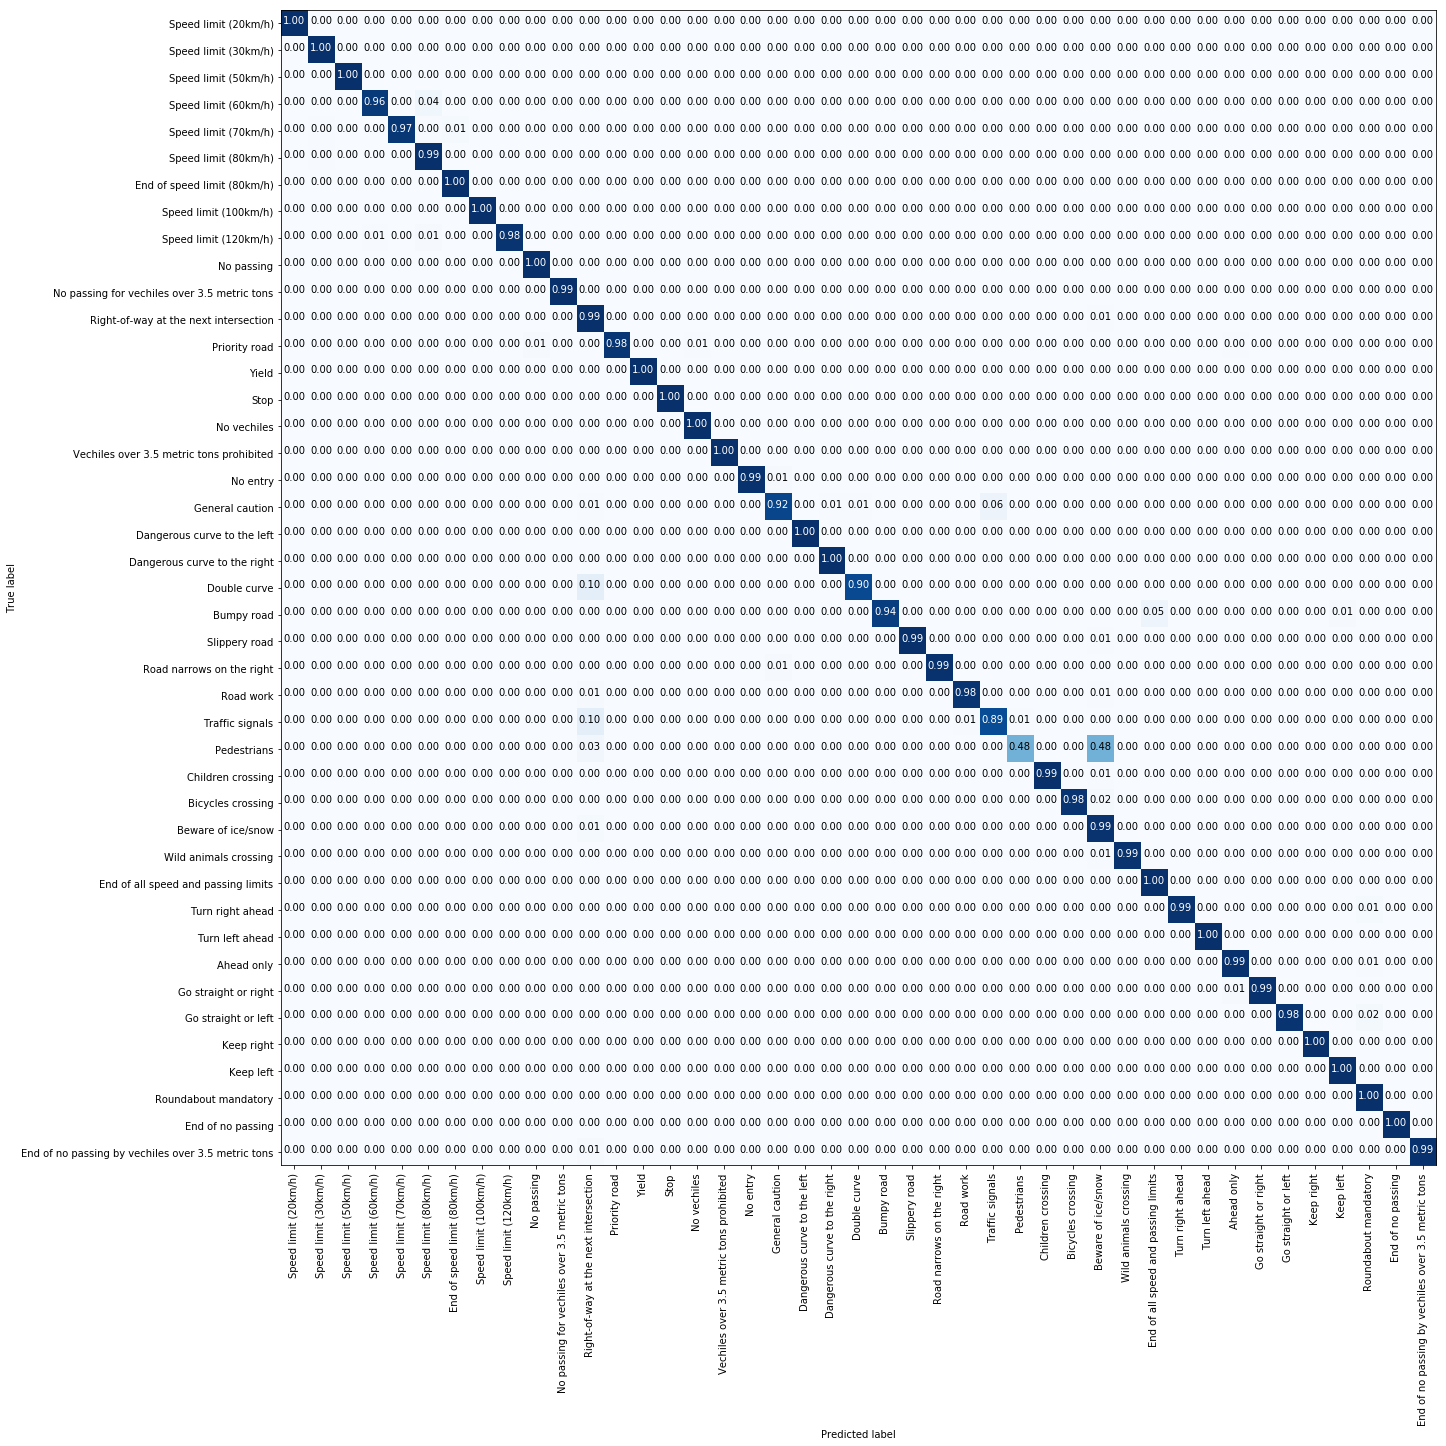

In [20]:
cm = confusion_matrix(rn, vp)

csort = [class_names[str(k)] for k in sorted([int(v) for v in list(class_names)])]

def plot_cm(cmatrix, labs):
    """
    plots confusion matrices
    """
    cmatrix = cmatrix.astype('float') / cmatrix.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize = (20,20))
    plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(len(labs))
    plt.xticks(tick_marks, labs, rotation=90)
    plt.yticks(tick_marks, labs)
    thresh = cmatrix.max() / 2.
    for i, j in itertools.product(range(cmatrix.shape[0]), range(cmatrix.shape[1])):
        plt.text(j, i, format(cmatrix[i, j], '.2f'),
                horizontalalignment="center",
                color="white" if cmatrix[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    
plot_cm(cm, csort)

### Run 1 Post Mortem:
Good performance, at first glance. Looks like all the biggest chunk in errors occurs between "Pedestrians" (27) and "Beware of ice/snow" (30). Let's check that out.


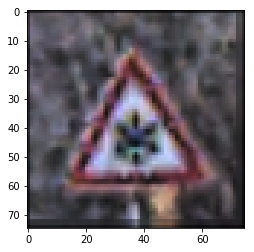

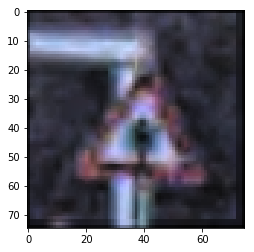

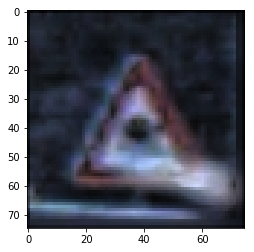

In [33]:
prb = X_test[rn == 30,:,:,:]

for i in range(3):
    plt.imshow(prb[i, :, :, :])
    plt.show()

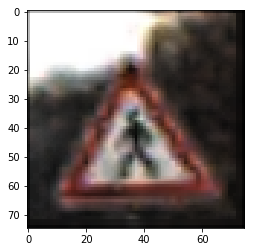

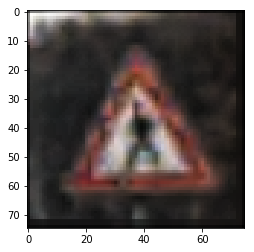

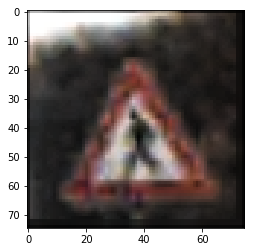

In [34]:
prb = X_test[rn == 27,:,:,:]

for i in range(3):
    plt.imshow(prb[i, :, :, :])
    plt.show()

These are incredibly similar signs, with central legged black pictograms on a red-bordered white triangle. But how can we help disambiguate them?

Let's look at the input data to see if it needs any augmentation.

In [30]:
from collections import Counter
Counter(labels)

Counter({0: 210,
         1: 2220,
         2: 2250,
         3: 1410,
         4: 1980,
         5: 1860,
         6: 420,
         7: 1440,
         8: 1410,
         9: 1470,
         10: 2010,
         11: 1320,
         12: 2100,
         13: 2160,
         14: 780,
         15: 630,
         16: 420,
         17: 1110,
         18: 1200,
         19: 210,
         20: 360,
         21: 330,
         22: 390,
         23: 510,
         24: 270,
         25: 1500,
         26: 600,
         27: 240,
         28: 540,
         29: 270,
         30: 450,
         31: 780,
         32: 240,
         33: 689,
         34: 420,
         35: 1200,
         36: 390,
         37: 210,
         38: 2070,
         39: 300,
         40: 360,
         41: 240,
         42: 240})

TODO:

Future Improvements -- Augment Pedestrian/Ice+Snow in training set to help disambiguate.
Create an image data generator that will aid in disambiguation. 90 degree rotation could help?